In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load cleaned_movies into DataFrame
movies_df = pd.read_csv('movies_final.csv')

# Drop Unnamed column
movies_df = movies_df.loc[:,~movies_df.columns.str.contains('^Unnamed')]

# Drop relase date columns
movies_df = movies_df.drop(columns=['released'], axis=1)
movies_df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,gross,company,runtime
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,39846344.0,Orion Pictures,98.0


In [3]:
# Load inflation indexer data
inflation_df = pd.read_csv('CPIAUCNS.csv')

# Change object to float
inflation_df['CPIAUCNS_NBD20210101'] = pd.to_numeric(inflation_df['CPIAUCNS_NBD20210101'], errors='coerce')

# Check for nulls
inflation_df['CPIAUCNS_NBD20210101'].isnull().sum()

1

In [4]:
# Drop nulls
inflation_df = inflation_df.dropna()
inflation_df

,DATE,CPIAUCNS_NBD20210101
0,1913-01-01,3.64739
1,1914-01-01,3.69660
2,1915-01-01,3.73043
3,1916-01-01,4.01644
4,1917-01-01,4.73300
...,...,...
104,2017-01-01,90.46013
105,2018-01-01,92.66969
106,2019-01-01,94.34906
107,2020-01-01,95.51294


In [5]:
# Create index multiplier
inflation_df['CPI_Multiplier'] = inflation_df['CPIAUCNS_NBD20210101'].iloc[-1] / inflation_df['CPIAUCNS_NBD20210101']
inflation_df

,DATE,CPIAUCNS_NBD20210101,CPI_Multiplier
0,1913-01-01,3.64739,27.416865
1,1914-01-01,3.69660,27.051886
2,1915-01-01,3.73043,26.806561
3,1916-01-01,4.01644,24.897671
4,1917-01-01,4.73300,21.128248
...,...,...,...
104,2017-01-01,90.46013,1.105459
105,2018-01-01,92.66969,1.079101
106,2019-01-01,94.34906,1.059894
107,2020-01-01,95.51294,1.046979


In [6]:
# Delete everything after year in DATE
inflation_df['DATE'] = inflation_df['DATE'].str.split('-').str[0]
inflation_df

,DATE,CPIAUCNS_NBD20210101,CPI_Multiplier
0,1913,3.64739,27.416865
1,1914,3.69660,27.051886
2,1915,3.73043,26.806561
3,1916,4.01644,24.897671
4,1917,4.73300,21.128248
...,...,...,...
104,2017,90.46013,1.105459
105,2018,92.66969,1.079101
106,2019,94.34906,1.059894
107,2020,95.51294,1.046979


In [7]:
# Change year to string prior to merge
movies_df['year'] = movies_df['year'].astype(str)
movies_df.dtypes

# Rename DATE column in inflation df to released to match prior to merge
inflation_df = inflation_df.rename(columns={'DATE':'year'})
inflation_df

,year,CPIAUCNS_NBD20210101,CPI_Multiplier
0,1913,3.64739,27.416865
1,1914,3.69660,27.051886
2,1915,3.73043,26.806561
3,1916,4.01644,24.897671
4,1917,4.73300,21.128248
...,...,...,...
104,2017,90.46013,1.105459
105,2018,92.66969,1.079101
106,2019,94.34906,1.059894
107,2020,95.51294,1.046979


In [8]:
# Merge dataframes
movies_df = pd.merge(movies_df, inflation_df, how = 'left', on= 'year')
movies_df

,name,rating,genre,year,score,votes,director,writer,star,country,gross,company,runtime,CPIAUCNS_NBD20210101,CPI_Multiplier
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,46998772.0,Warner Bros.,146.0,30.41237,3.288136
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,58853106.0,Columbia Pictures,104.0,30.41237,3.288136
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,538375067.0,Lucasfilm,124.0,30.41237,3.288136
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,83453539.0,Paramount Pictures,88.0,30.41237,3.288136
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,39846344.0,Orion Pictures,98.0,30.41237,3.288136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7407,The Call of the Wild,PG,Adventure,2020,6.8,42000.0,Chris Sanders,Michael Green,Harrison Ford,Canada,111105497.0,20th Century Studios,100.0,95.51294,1.046979
7408,The Eight Hundred,Not Rated,Action,2020,6.8,3700.0,Hu Guan,Hu Guan,Zhi-zhong Huang,China,461421559.0,Beijing Diqi Yinxiang Entertainment,149.0,95.51294,1.046979
7409,The Quarry,R,Crime,2020,5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,United States,3661.0,Prowess Pictures,98.0,95.51294,1.046979
7410,Tulsa,PG-13,Comedy,2020,5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,United States,413378.0,Pryor Entertainment,120.0,95.51294,1.046979


In [9]:
# Adjust gross revenue for inflation
movies_df['adjusted_gross'] = movies_df['gross']*movies_df['CPI_Multiplier']
movies_df

,name,rating,genre,year,score,votes,director,writer,star,country,gross,company,runtime,CPIAUCNS_NBD20210101,CPI_Multiplier,adjusted_gross
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,46998772.0,Warner Bros.,146.0,30.41237,3.288136,1.545383e+08
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,58853106.0,Columbia Pictures,104.0,30.41237,3.288136,1.935170e+08
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,538375067.0,Lucasfilm,124.0,30.41237,3.288136,1.770250e+09
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,83453539.0,Paramount Pictures,88.0,30.41237,3.288136,2.744066e+08
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,39846344.0,Orion Pictures,98.0,30.41237,3.288136,1.310202e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7407,The Call of the Wild,PG,Adventure,2020,6.8,42000.0,Chris Sanders,Michael Green,Harrison Ford,Canada,111105497.0,20th Century Studios,100.0,95.51294,1.046979,1.163251e+08
7408,The Eight Hundred,Not Rated,Action,2020,6.8,3700.0,Hu Guan,Hu Guan,Zhi-zhong Huang,China,461421559.0,Beijing Diqi Yinxiang Entertainment,149.0,95.51294,1.046979,4.830985e+08
7409,The Quarry,R,Crime,2020,5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,United States,3661.0,Prowess Pictures,98.0,95.51294,1.046979,3.832988e+03
7410,Tulsa,PG-13,Comedy,2020,5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,United States,413378.0,Pryor Entertainment,120.0,95.51294,1.046979,4.327979e+05


In [10]:
# Remove directors, writers, and stars with only 1 movie
columns = ['director','writer','star']
for column in columns:
    movies_df = movies_df[movies_df[column].map(movies_df[column].value_counts()) != 1]
movies_df

,name,rating,genre,year,score,votes,director,writer,star,country,gross,company,runtime,CPIAUCNS_NBD20210101,CPI_Multiplier,adjusted_gross
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,46998772.0,Warner Bros.,146.0,30.41237,3.288136,1.545383e+08
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,83453539.0,Paramount Pictures,88.0,30.41237,3.288136,2.744066e+08
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,39846344.0,Orion Pictures,98.0,30.41237,3.288136,1.310202e+08
5,Friday the 13th,R,Horror,1980,6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,39754601.0,Paramount Pictures,95.0,30.41237,3.288136,1.307185e+08
6,The Blues Brothers,R,Action,1980,7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,115229890.0,Universal Pictures,133.0,30.41237,3.288136,3.788915e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,Overcomer,PG,Drama,2019,6.6,4100.0,Alex Kendrick,Alex Kendrick,Alex Kendrick,United States,38026103.0,Affirm Films,119.0,94.34906,1.059894,4.030364e+07
7352,A Madea Family Funeral,PG-13,Comedy,2019,4.5,4000.0,Tyler Perry,Tyler Perry,Tyler Perry,United States,74747725.0,The Tyler Perry Company,109.0,94.34906,1.059894,7.922466e+07
7395,The Other Side of Heaven 2: Fire of Faith,PG-13,Adventure,2019,5.6,336.0,Mitch Davis,Mitch Davis,Christopher Gorham,United States,1807216.0,Kolipoki Pictures,117.0,94.34906,1.059894,1.915457e+06
7403,Onward,PG,Animation,2020,7.4,120000.0,Dan Scanlon,Dan Scanlon,Tom Holland,United States,141950608.0,Walt Disney Pictures,102.0,95.51294,1.046979,1.486192e+08


In [11]:
# Remove scores with only 1 value
movies_df = movies_df[movies_df['score'].map(movies_df['score'].value_counts()) != 1]
movies_df

,name,rating,genre,year,score,votes,director,writer,star,country,gross,company,runtime,CPIAUCNS_NBD20210101,CPI_Multiplier,adjusted_gross
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,46998772.0,Warner Bros.,146.0,30.41237,3.288136,1.545383e+08
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,83453539.0,Paramount Pictures,88.0,30.41237,3.288136,2.744066e+08
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,39846344.0,Orion Pictures,98.0,30.41237,3.288136,1.310202e+08
5,Friday the 13th,R,Horror,1980,6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,39754601.0,Paramount Pictures,95.0,30.41237,3.288136,1.307185e+08
6,The Blues Brothers,R,Action,1980,7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,115229890.0,Universal Pictures,133.0,30.41237,3.288136,3.788915e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,Overcomer,PG,Drama,2019,6.6,4100.0,Alex Kendrick,Alex Kendrick,Alex Kendrick,United States,38026103.0,Affirm Films,119.0,94.34906,1.059894,4.030364e+07
7352,A Madea Family Funeral,PG-13,Comedy,2019,4.5,4000.0,Tyler Perry,Tyler Perry,Tyler Perry,United States,74747725.0,The Tyler Perry Company,109.0,94.34906,1.059894,7.922466e+07
7395,The Other Side of Heaven 2: Fire of Faith,PG-13,Adventure,2019,5.6,336.0,Mitch Davis,Mitch Davis,Christopher Gorham,United States,1807216.0,Kolipoki Pictures,117.0,94.34906,1.059894,1.915457e+06
7403,Onward,PG,Animation,2020,7.4,120000.0,Dan Scanlon,Dan Scanlon,Tom Holland,United States,141950608.0,Walt Disney Pictures,102.0,95.51294,1.046979,1.486192e+08


In [12]:
# Generate our categorical variable list
movies_cat = movies_df.dtypes[movies_df.dtypes == "object"].index.tolist()

# Remove name from categorical list
movies_cat.pop(0)
movies_cat

['rating', 'genre', 'year', 'director', 'writer', 'star', 'country', 'company']

In [13]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(movies_df[movies_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(movies_cat)
encode_df.head()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_Unrated,rating_X,genre_Action,genre_Adventure,...,company_World Film Services,company_Worldview Entertainment,company_X-Filme Creative Pool,company_Yari Film Group (YFG),company_Yellow Bird,company_Zentropa Entertainments,company_Zeta Entertainment,company_Zoetrope Studios,company_Zucker Brothers Productions,company_Zupnik-Curtis Enterprises
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Merge one-hot encoded features and drop the originals
movies_df = movies_df.merge(encode_df,left_index=True, right_index=True)
movies_df = movies_df.drop(movies_cat,1)
movies_df.head()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,name,score,votes,gross,runtime,CPIAUCNS_NBD20210101,CPI_Multiplier,adjusted_gross,rating_G,rating_NC-17,...,company_World Film Services,company_Worldview Entertainment,company_X-Filme Creative Pool,company_Yari Film Group (YFG),company_Yellow Bird,company_Zentropa Entertainments,company_Zeta Entertainment,company_Zoetrope Studios,company_Zucker Brothers Productions,company_Zupnik-Curtis Enterprises
0,The Shining,8.4,927000.0,46998772.0,146.0,30.41237,3.288136,1.545383e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Airplane!,7.7,221000.0,83453539.0,88.0,30.41237,3.288136,2.744066e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Caddyshack,7.3,108000.0,39846344.0,98.0,30.41237,3.288136,1.310202e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Friday the 13th,6.4,123000.0,39754601.0,95.0,30.41237,3.288136,1.307185e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,The Blues Brothers,7.9,188000.0,115229890.0,133.0,30.41237,3.288136,3.788915e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Create target and features data
X = movies_df.drop(columns=['score','name','gross','CPIAUCNS_NBD20210101','CPI_Multiplier'])
y = movies_df['score']

In [16]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Determine best hyperparameters for random forest model
# Number of trees
n_estimators = [30,40]
# Number of features to consider at each split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [4,5,6]
# Minimum mumber of samples required to split a node
min_samples_split = [10,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,5,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [18]:
# Create a random param grid
param_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

In [19]:
# Create a random forest regression model
rf_model = RandomForestRegressor()

In [20]:
# Perform a grid search for the best parameters
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator= rf_model, param_grid = param_grid, cv=3, verbose=2, n_jobs=4)
rf_Grid.fit(X_train_scaled, y_train)
rf_Grid.best_params_
# output with no filtering: {'bootstrap': True,
# 'max_depth': 4,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 10,
# 'n_estimators': 30}
# output with removed 1s: {'bootstrap': True,
# 'max_depth': 6,
# 'max_features': 'auto',
# 'min_samples_leaf': 5,
# 'min_samples_split': 20,
# 'n_estimators': 40}
# output of additional grid search {'bootstrap': True,
# 'max_depth': 6,
# 'max_features': 'auto',
# 'min_samples_leaf': 5,
# 'min_samples_split': 10,
# 'n_estimators': 40}

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 40}

In [21]:
# Get metrics of GridSearch model (r2 score)
rf_Grid.best_score_

0.44789673998777024

In [31]:
# Create an instance of random forest model with best params
rf = RandomForestRegressor(bootstrap= True, max_depth= 6, max_features= 'auto', min_samples_leaf=6,
                           min_samples_split=10,n_estimators=40)

In [32]:
# Fitting the model
rf = rf.fit(X_train_scaled, y_train)

# Evaluate the model (r2 score)
y_pred = rf.predict(X_test_scaled)
rf.score(X_test_scaled, y_test)

0.4146153614127944

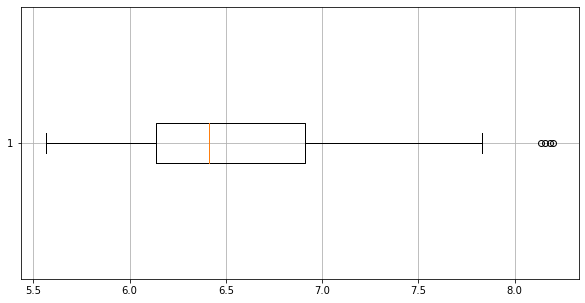

In [33]:
# Boxplot of predicted IMDb scores
fig,ax = plt.subplots(figsize=(10,5))
ax.boxplot(y_pred,vert=False)
ax.grid()
plt.show()

In [34]:
# Determine RMSE (root mean square error)
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = sqrt(mse)
rmse

0.7792138804832088

In [35]:
# Determine the MAE (mean absolute error)
mae = mean_absolute_error(y_test,y_pred)
mae

0.46804268880715993

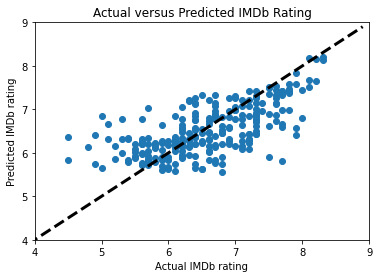

In [36]:
# Plot actual vs. predicted rating
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=3)
ax.set_xlabel('Actual IMDb rating')
ax.set_ylabel('Predicted IMDb rating')
plt.title('Actual versus Predicted IMDb Rating')
plt.ylim((4, 9))
plt.xlim(4, 9) 
plt.show()

In [37]:
# Create DataFrame of actual and predicted rating
test_pred = pd.DataFrame(
    {'Actual IMDb rating':y_test,
    'Predicted IMDb rating':y_pred})
test_pred

,Actual IMDb rating,Predicted IMDb rating
2597,6.4,6.744029
1809,5.8,6.137554
1968,5.1,6.672695
1518,7.9,7.828297
1064,5.6,5.713594
...,...,...
381,6.1,5.573369
2670,7.3,7.418031
260,5.5,5.875436
301,8.3,8.199398


In [38]:
# Get names of movies
names_df = pd.DataFrame({'name': movies_df['name']})
names_df

,name
0,The Shining
3,Airplane!
4,Caddyshack
5,Friday the 13th
6,The Blues Brothers
...,...
2789,The Portrait of a Lady
2794,Flirting with Disaster
2795,Homeward Bound II: Lost in San Francisco
2797,Ghosts of Mississippi


In [39]:
# Merge dataframes
actual_vs_predicted = pd.merge(test_pred, names_df, left_index=True, right_index=True)
# Change order of columns
actual_vs_predicted = actual_vs_predicted.reindex(columns=['name','Actual IMDb rating','Predicted IMDb rating'])
# Format predicted column
actual_vs_predicted['Predicted IMDb rating'] = actual_vs_predicted['Predicted IMDb rating'].map('{:.2f}'.format)
actual_vs_predicted

,name,Actual IMDb rating,Predicted IMDb rating
2597,Screamers,6.4,6.74
1809,Johnny Suede,5.8,6.14
1968,Toys,5.1,6.67
1518,Edward Scissorhands,7.9,7.83
1064,Light of Day,5.6,5.71
...,...,...,...
381,Revenge of the Ninja,6.1,5.57
2670,Scream,7.3,7.42
260,Best Friends,5.5,5.88
301,Scarface,8.3,8.20
